# Equivariant Neural Rendering

In [1]:
import random, os, sys
import cv2
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import image as mpimg
%matplotlib inline
sns.set() # Setting seaborn as default style even if use only matplotlib
sns.set_style("whitegrid", {'axes.grid' : False})
import imageio
import torch
import torchvision
from torchvision.transforms import ToTensor


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

""" Detect local path """
local_path = !pwd
local_path = local_path[0]
main_path = local_path[:-5]


sys.path.append(local_path + '/../src/')
sys.path.append(local_path + '/../src/enr/')
from models.neural_renderer import *




## 1. Introduction


The paper from Dupont et al. introduces an approach to render 2D images into implicit, equivariant 3D representations. The authors argue that the scene representations need not be explicit, as long as the transformations to it occur in an equivariant manner. Their model is trained on a dataset of rotation symmetries, learning to produce novel views from a single image of a scene.

Current approaches in scene representations present difficulties with scalability. Voxel grids, point clouds and other traditional methods have high computational and memory requirements. Reconstrucion from incomplete or noisy data is also a challenging task with these methods, often requiring 3D information during training. Generating novel views of a scene given some input views presents the same difficulties. Finally, traditional neural networks are not equivariant with respect to general transformation groups. 3D equivariance especially requires specifc techniques like steerable filters. The authors attempt to solve these problems by proposing a new method which results in more scalable, implicit representations that are also equivariant with respect to transformations. 

The difference between an explicit scene representation (mesh grid) and an implicit one can be seen in the figure below:

![Alt text](../src/imgs/paper_screenshots/fig2.png)

  
### 1.1: Methodology

The proposed model uses a series of convolutions to map scene representations to images. Specifically, the scene representation is passed through 3D convolutions, followed by 1x1 convolutions and a set of 2D convolutions that maps them to image space. The reverse renderer is the transpose of this operation. Equivariance is enforced by applying transformations in both the scene and image spaces. Because the representation space is a deep voxel grid, the transformations in this space are defined by a 3D rotation matrix. Inverse warping with trilinear interpolation is also used in the model, to reconstruct the values after rotations.

![Alt text](../src/imgs/paper_screenshots/fig5.png)

For training, two images of the same scene are passed through the renderer. Then, the 3D transformation grid is applied in the representation space to turn one into the other, before passing them to the inverse renderer. Finally, the output images are compared to the original inputs to obtain the loss values. Training in this manner ensures the model learns equivariant representations, as the loss evaluates both the actual rendering and the accuracy of the matching transformations from both spaces.

![Alt text](../src/imgs/paper_screenshots/fig4.png)

Finally, the authors claim that the rendering loss used makes little change in results. They provide l1 norm, l2 norm and SSIM loss as candidates, and conduct ablation studies to determine the tradeoffs between them.

### 1.2: Datasets
The authors evaluate their model on 4 datasets, including two ShapeNet benchmarks as well as two novel datasets of the authors design. They use an image size of 128 x 128 and a representation size of 64 x 32 x 32 x 32.
The datasets are presented in table 1. 


| *Dataset*  | *Source*  |  *Sample* | *# Scenes*  |*# images per scene*| *# datapoints*|
|---|---|---|---|---||
| Chairs  | [ShapeNet](https://icml20-prod.cdn-apple.com/eqn-data/data/chairs.zip)  | ![Chair](../src/imgs/paper_screenshots/chair.png)  |  6591 | 50  | 329 550|
| Cars  |  [ShapeNet](https://icml20-prod.cdn-apple.com/eqn-data/data/cars.zip) | ![Car](../src/imgs/paper_screenshots/car.png)  |  3514 |  50 | 175 700|
| MugsHQ  |  [Apple](https://icml20-prod.cdn-apple.com/eqn-data/data/mugs.zip) | ![Mug](../src/imgs/paper_screenshots/mug.png)  |  214 | 150  | 32 100|
| 3D mountainset  |  [Apple](https://icml20-prod.cdn-apple.com/eqn-data/data/mountains.zip) | ![Mountain](../src/imgs/paper_screenshots/mountain.png)  |  559 |  50 | 27 950|

Table 1.: *Overview of datasets considered for equivariant neural rendering by Dupont et al.*

### 1.3: Experiments of paper

The proposed model is compared against three baseline models, each one making assumptions much stronger than the original study.

|   | TCO  |  DGQN | SRN  | Proposed model  |
|---|---|---|---|---|
| Requires Absolute Pose  | Yes  | Yes | Yes | No |
| Requires Pose at Inference Time  | No  | Yes | Yes | No |
| Optimization at Inference Time  | No  | No | Yes | No |

The qualitative comparisons against the baseline models in single shot novel view synthesis with the ShapeNet chairs dataset reveals that the model achieves similar to SoTA results while making far fewer assumptions than the other methods. It can produce high quality novel views by achieving the desired equivariant transformation in representation space.

![Alt text](../src/imgs/paper_screenshots/results.png)

Results similar to the chairs were reported in the other datasets, with some variations due to the specific challenges of each one. For example, the mountains contain extremely complex geometric information, which severly limits the detail of the novel view synthesis.

![Alt text](../src/imgs/paper_screenshots/chairs.png) 

![Alt text](../src/imgs/paper_screenshots/cars.png) 

![Alt text](../src/imgs/paper_screenshots/mugs.png) 

![Alt text](../src/imgs/paper_screenshots/mountains.png)

Finally, the authors performed ablation studies to test novel view synthesis when using different loss functions. The results in each one were similar and no inherent prefered approach was suggested. In the end, they reason that choice of loss function is task specific.


### 1.4 Demo of Original work 

The subsequent section presents a demonstration of the model capabilities of the model produced by Dupont et al. You may adjust the transformation parameters in order to transform the representation and render an input image from a new view.

**Configure Transformations**

In [2]:
# ---------------------------------------------------------
# Configure transformations for demonstration
# ---------------------------------------------------------

def transformation_dict(azimuth = 0., elevation = 0., x = 0., y = 0., z = 0.):
    """ Store transformations in dictionary
    
    Args:
        azimuth (angle): Positive (negative) values correspond to moving camera to the right (left)
        Elevation (angle): Positive (negative) values correspond to moving camera up (down)
        x, y, z (scalar units): translations along x, y, z axis 
    """
    transformations = {}
    
    # Rotation values
    transformations['azimuth'] = torch.Tensor([azimuth]).to(device)
    transformations['elevation'] = torch.Tensor([elevation]).to(device)

    # Translation values
    transformations['xyz'] = torch.Tensor([x, y, z]).to(device)

    print('Transformations: ', transformations)
    return transformations

In [3]:
"""
In this cell you can configure the transformations you wish 
to apply to the rendered image. You can set these to any value you like!
"""

# Transformed view
transformations = transformation_dict(azimuth = 30., elevation = 30., 
                                      x = 0., y = -.2, z = .2)

# initial view
init_camera_pos = transformation_dict()

Transformations:  {'azimuth': tensor([30.], device='cuda:0'), 'elevation': tensor([30.], device='cuda:0'), 'xyz': tensor([ 0.0000, -0.2000,  0.2000], device='cuda:0')}
Transformations:  {'azimuth': tensor([0.], device='cuda:0'), 'elevation': tensor([0.], device='cuda:0'), 'xyz': tensor([0., 0., 0.], device='cuda:0')}


**Define some helper functions**

In [13]:
def tensor_to_image(img, nrow=4):
    """Helper function to plot image tensors.
    
    Args:
        img (torch.Tensor): Image or batch of images of shape 
            (batch_size, channels, height, width).
    """
    
    img_grid = torchvision.utils.make_grid(img, nrow=nrow)
    return img_grid.cpu().numpy().transpose(1, 2, 0)

def render_image(model_path, img_path, downsample = False):
    # ---------------------------------------------------------
    # Loading the original image
    # ---------------------------------------------------------
    # Load trained chairs modellocal_path
    model = load_model(model_path).to(device)

    # You can also try loading other examples (e.g. 'chair1.png')
    original_img = plt.imread(img_path)
    
    if downsample:
        # Convert image to tensor and add batch dimension
        original_img = cv2.resize(original_img, dsize=(64, 64), interpolation=cv2.INTER_AREA)
        
    img_source = ToTensor()(original_img)
    img_source = img_source.unsqueeze(0).to(device)
    print(img_source.shape)
    if img_source.shape[2] != 3:
        img_source = img_source[:, 0:3, : , :]
        print(img_source.shape)
    # ---------------------------------------------------------
    # Render original image without transformations
    # ---------------------------------------------------------

    # Infer scene representation
    scene = model.inverse_render(img_source)

    # We can render the scene representation without transforming it
    rendered = model.render(scene)
    rendered_img = tensor_to_image(rendered.detach())
    
    return scene, model, original_img, rendered_img

def transform_scene(model,scene, init_camera_pos, transformations):
    """Helper function to transform scene
    
    Args: 
        model: model used to render scene
        scene: implicit scene representation
        transformations (dict): dict comprised of keys
            azimuth (angle): Positive (negative) values correspond to moving camera to the right (left)
            elevation (angle): Positive (negative) values correspond to moving camera up (down)
            Translations (dict): translation values with dictionary elements corresponding to 'x', 'y', 'z'
            
     As a rotation matrix can feel a little abstract, we can also reason in terms of 
         camera azimuth and elevation. The initial coordinate at which the source image
         is observed is given by the following azimuth and elevation. Note that these
         are not necessary to generate novel views (as shown above), we just use them 
         for convenience to generate rotation matrices
    """
    # Set Transformations and Configure output view
    azimuth_target = init_camera_pos['azimuth'] + transformations['azimuth']
    elevation_target = init_camera_pos['elevation'] + transformations['elevation']
    translations_target = init_camera_pos['xyz'] + transformations['xyz']

    # Rotate scene to match target camera angle
    transformed_scene = model.rotate_source_to_target(
        scene, 
        init_camera_pos['azimuth'], init_camera_pos['elevation'], init_camera_pos['xyz'],
        azimuth_target, elevation_target, translations_target)
    
    # Render rotated scene
    rendered = model.render(transformed_scene)
    image = tensor_to_image(rendered.detach())
    
    return image

def display_transformations(imgs, keys, fsize = (8, 6)):
    """ Helper function to make suplot displaying images
    
    Args:
        imgs (list): list of images to display
        keys (list): list of plot titles
        fsize (2-touple): figure size
    """
    N = len(imgs)
    fig, axs = plt.subplots(1, N, figsize=fsize)
    for ax, idx in zip(axs, range(N)):
        ax.imshow(imgs[idx])
        ax.title.set_text(keys[idx])
        
    return fig

**Loading, plotting & transforming the original image**

The model infers from a single image and renders a second image from a novel view.

torch.Size([1, 3, 128, 128])
Transformations:  {'azimuth': tensor([30.], device='cuda:0'), 'elevation': tensor([0.], device='cuda:0'), 'xyz': tensor([0., 0., 0.], device='cuda:0')}
Transformations:  {'azimuth': tensor([0.], device='cuda:0'), 'elevation': tensor([0.], device='cuda:0'), 'xyz': tensor([ 0.0000, -0.2000,  0.0000], device='cuda:0')}


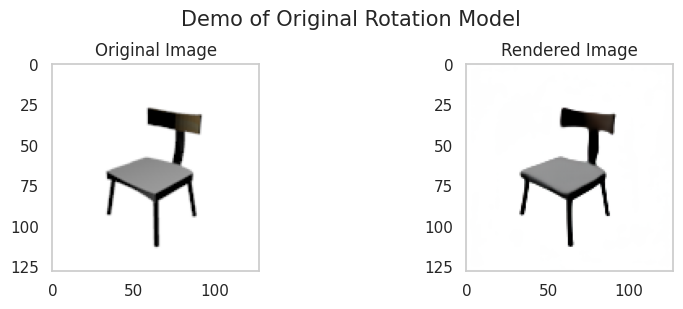

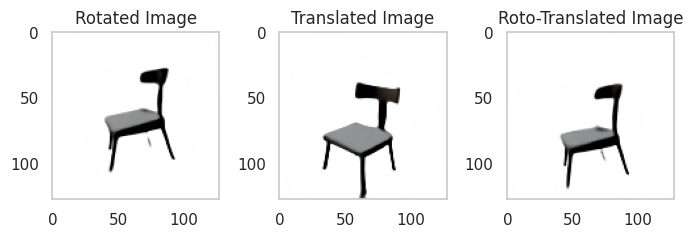

In [10]:
# ---------------------------------------------------------
# Loading the original image
# ---------------------------------------------------------
# Load trained chairs modellocal_path
model_path = main_path + 'src/train_results/original/chairs.pt'

# You can also try loading other examples (e.g. 'chair1.png')
img_path  = main_path + 'src/imgs/example-data/chair4.png'

scene, model, original_img, rendered_img = render_image(model_path, img_path)

# ---------------------------------------------------------
# Transform and render image 
# ---------------------------------------------------------

# Rotate scene
rotations = transformation_dict(azimuth = transformations['azimuth'], elevation = transformations['elevation'])
roto_scene = transform_scene(model, scene,init_camera_pos, rotations)


# Translate Scene
translations = transformation_dict(x = transformations['xyz'][0], 
                                   y = transformations['xyz'][1], 
                                   z = transformations['xyz'][2])
trans_scene = transform_scene(model, scene, init_camera_pos, translations)

# Roto-Translate Scene
roto_trans_scene = transform_scene(model, scene, init_camera_pos, transformations)



# ---------------------------------------------------------
# Loading and plotting the original image
# ---------------------------------------------------------


images = [original_img, rendered_img, roto_scene, trans_scene, roto_trans_scene]
keys = ['Original Image', 'Rendered Image', 'Rotated Image', 'Translated Image', 'Roto-Translated Image']

# Plot without transformations
fig = display_transformations(images[:2], keys[:2], fsize = (9.8, 3))    
fig.suptitle('Demo of Original Rotation Model', size = 15)
fig.subplots_adjust(top=0.8)

# Plot with transformations
fig = display_transformations(images[2:], keys[2:], fsize = (7, 3))
plt.tight_layout()

## 2. Response 

Much of the success of Deep Learning can be attributed to effective representation learning. Such representations do not need to be humanly interpretable, but can also be abstract. The original authors proposed an implicit 3D representation of the scene, instead of an explicit 3D representation such as mesh-grids or point clouds. By removing the need for an explicit 3D representation, they developed a model that requires no 3D supervision. It only requires 2D images with the corresponding rotation angle of the camera, that was used between these images. Their model can generate a novel view from a single image. The qualitative results of their model’s performance motivated us to extent their research.

In the original paper the authors used 3D rotations to generate novel views, meaning that they rotate a camera on a sphere around the scene. 3D rotations do not act transitively on 3D space. Therefore, we proposed to extend their model to roto-translations, with the intermediate proof-of-concept step of using translations only. The objective was to obtain a model that can generate a novel view for any camera position in 3D space, within a reasonable range of movement.

## 3. Novel Contribution

In this section we describe the novel contributions of our research.

- We introduce a method to generate training data for the equivariant neural rendering models (section 3.1).

- We show that the original model, which was solely pretrained on rotations, can already generate plausible translations along the axes running parallel to the image plane (i.e. orthogonal to the line of sight) through inductive bias (section 3.2).

- We introduce a model that has been trained on translations and a model that has been trained on roto-translations (section 3.3). This part constitutes the main contribution of our research.







### 3.1 Datasets

The authors present datasets consisting of rotational transformations. However, they do not provide instructions or tools for further data generation. To address this limitation we developed a new pipeline using blender for producing images of 3D-models under rotations, translations and roto-translations. Our pipeline can be used to increase the size of the training data, or to extend training data to new transformation groups.

The following section demonstrates the practical application of our pipeline for data production, by demonstrating how to use blender to generate new training data containing roto-translations.

#### 3.1.1  Demonstration: populating datasets for the ISO(3)-group using Blender 
Similar to Dupont et al., we perform experiments on the [ShapeNet Core](https://shapenet.org/download/shapenetcore)-Chairs benchmark. It is worth noting that the objects included in the ShapeNetCore dataset are already normalized and consistently aligned. However, the subsequent pipeline can be adapted to accommodate any 3D-object data that is processable by Blender. Here follows a brief demonstration of how data can be constructed using Blender 3.5.1.


**Run the subsequent cells once to install Blender with wget**

_NB! Installation assumes Linux-based OS._




In [ ]:
""" Install / Load wget """
%pip install wget
import wget

""" Install blender """
# Download blender 3.5.1
!wget https://ftp.nluug.nl/pub/graphics/blender/release/Blender3.5/blender-3.5.1-linux-x64.tar.xz

# Unpack 
!tar -xvf blender-3.5.1-linux-x64.tar.xz
!rm {local_path}/blender-3.5.1-linux-x64.tar.xz

# Move and rename for shorter commands
!mv {local_path}/blender-3.5.1-linux-x64 {main_path}src/enr/data/demo/blender


_Run render demo_

In order to build a roto-translational dataset pass both command line arguments: _--rotation --translation_ . To build a dataset composed only of rotations or translations pass only the singular argument respectively.

In [ ]:
""" Run Demo"""
!{main_path}src/enr/data/demo/blender/blender -b --python {main_path}src/enr/data/demo/render_blender.py -- --scene_name data --rotation --translation --scene_folder src/enr/data/demo/data/model_1 --local_path {main_path}

_Display demonstration of roto-translation dataset_

In [ ]:
""" Display random sample outputs """
# Load 3 random images from output directory
path = main_path + "src/enr/data/demo/output/rot_trans_dataset/data/"
random_file = [random.choice(os.listdir(path)) for img in range(3)]
images = [mpimg.imread(path + image) for image in random_file]

# Plot sampleset
fig, axs = plt.subplots(1, 3, figsize=(7, 3))
for ax, id in zip(axs, range(3)):
    ax.imshow(images[id])
plt.title('Demonstration of dataset production: Roto-translations of chair model\n', loc='right')
plt.show()

#### 3.1.2 Populating new datasets

We use the afformention pipeline to build 3 new datasets: 

   * _Rotations_: used to reproduce the results presented by Dupont et al.
   * _Translations_: used to train a model with higher capacity for translation invariance.
   * _Roto-translations_: used to train a roto-translational invariant model.
    
We downscale the datasets in order to reduce the computational costs of training the new models. For all three datasets we use the partitioning described in table 2. 


|   | **# Scenes**  |  **# Images per scene** | **Resolution**  | **# datapoints**  |
|---|---|---|---|---|
| Train  | 2306  |  50 | 64 x 64  |  115300 |
| Validataion  | 331  | 50  |  64 x 64 | 16550  |

Table 2: _Partition of new datasets_


| **Hyperparameter**  | **R**  |  **X** | **Y**  | **Z**  | **Resolution** |
|---|---|---|---|---|---|
|   | 1.5  | [-0.4, 0.4]  | [-0.3, 0.5]  | [-0.4, 0.4] | 64 x 64|

Table 3: _Hyperparameters used when populating the new dataset._

We construct the datasets by sampling poses from various views. In case of rotations the camera is placed on a sphere with a radius **R**. For each view, a value between 0 and $2\pi$ is uniformly sampled for the elevation and azimuth angle of the camera and rotated accordingly. In case of translations, for each view, a value is uniformly sampled from a range of **X**, **Y** and **Z** locations of the chair.

### 3.2 Translations through inductive bias

Through inductive bias, (reasonably small) translations, which are orthogonal to the line of sight, already work on the model that has only been trained on rotations. This is due to the fact that the model uses a CNN architecture, which is translationally equivariant along the image plane. Still, it seems interesting that the model does not seem to encode any information from the outside of the object to produce a good estimation.

*** More investigation necessary here (check if zero background is mapped to zero in 3D representation, check if translation introduces zero-padding in 3D presentation, check if zeros in 3D representation are mapped to zeros in image) ***

#### Translations only

In [ ]:
translations = transformation_dict(y = .3, z = .3)
trans_scene = transform_scene(model, scene, init_camera_pos, translations)

imgs = [original_img, trans_scene]
keys = ['original image', 'translated image']

fig = display_transformations(imgs, keys)

#### Roto-translations

In [ ]:
roto_translations = transformation_dict(azimuth = 30., elevation = 30., y = .3, z = .3)
roto_trans_scene = transform_scene(model, scene, init_camera_pos, roto_translations)

imgs = [original_img, roto_trans_scene]
keys = ['original image', 'Roto-translated image']

fig = display_transformations(imgs, keys)



Nonetheless, translations along the line of sight do not work out-of-the-box and require explicit training. The reason for that is that the equivariant neural rendering model considers the depth dimension via incorporating its information into the channels of the CNN. More concrete, the model uses the following code:

```python
# Reshape 3D -> 2D
reshaped = inputs.view(batch_size, channels * depth, height, width)
```

Furthermore, due to the central positioning of the objects in the images, the model has problems rendering scenes that extent to the image boundaries. Therefore, we trained our model on translations first, before moving on to roto-translations

In [ ]:
roto_translations = transformation_dict(x = .5)
roto_trans_scene = transform_scene(model, scene,init_camera_pos, roto_translations)

imgs = [original_img, roto_trans_scene]
keys = ['original image', 'Translated image (x-axis)']

fig = display_transformations(imgs, keys)

### 3.3 Extending the model

#### 3.3.0 Reproducing rotations with our dataset
![image](../src/imgs/output/rotations.gif)

torch.Size([1, 4, 64, 64])
torch.Size([1, 3, 64, 64])
Transformations:  {'azimuth': tensor([1.7837], device='cuda:0'), 'elevation': tensor([3.4286], device='cuda:0'), 'xyz': tensor([0., 0., 0.], device='cuda:0')}
Transformations:  {'azimuth': tensor([1.7837], device='cuda:0'), 'elevation': tensor([3.4286], device='cuda:0'), 'xyz': tensor([0., 0., 0.], device='cuda:0')}
Transformations:  {'azimuth': tensor([0.], device='cuda:0'), 'elevation': tensor([0.], device='cuda:0'), 'xyz': tensor([0., 0., 0.], device='cuda:0')}


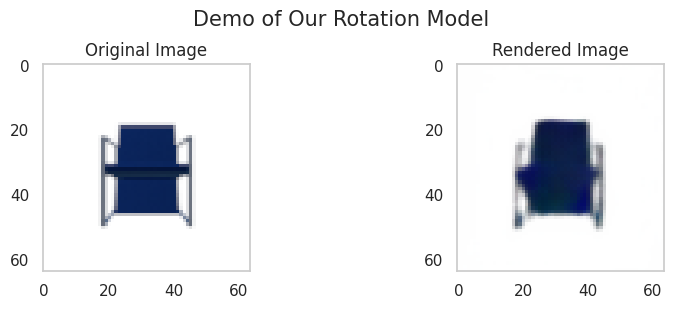

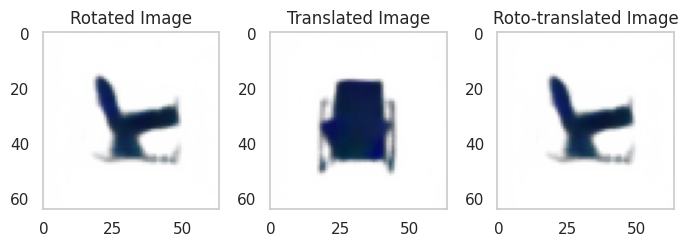

In [23]:
""" DEMO: We are currently downsampling the image but lose quite a bit of the image quality doing this
"""

# Load trained chairs modellocal_path
model_path = main_path + 'src/train_results/2023-05-10_12-31_roto_lr2e-4/best_model.pt'

# You can also try loading other examples (e.g. 'chair1.png')
img_path  = main_path + 'src/imgs/example-data/rotation_train_scene/00000.png'

scene, model, original_img, rendered_img = render_image(model_path, img_path, downsample = False)

# ---------------------------------------------------------
# Transform and render image 
# ---------------------------------------------------------
transformations = transformation_dict(1.7836589022812777, 3.428603365040415, 0., 0., 0.)
# Rotate scene
rotations = transformation_dict(azimuth = transformations['azimuth'], elevation = transformations['elevation'])
roto_scene = transform_scene(model, scene,init_camera_pos, rotations)


# Translate Scene
translations = transformation_dict(x = transformations['xyz'][0], 
                                   y = transformations['xyz'][1], 
                                   z = transformations['xyz'][2])
trans_scene = transform_scene(model, scene,init_camera_pos, translations)

# Roto-Translate Scene
roto_trans_scene = transform_scene(model, scene,init_camera_pos, transformations)


images = [original_img, rendered_img, roto_scene, trans_scene, roto_trans_scene]
keys = ['Original Image', 'Rendered Image', 'Rotated Image', 'Translated Image', 'Roto-translated Image']

# Plot without transformations
fig = display_transformations(images[:2], keys[:2], fsize = (9.8, 3))    
fig.suptitle('Demo of Our Rotation Model', size = 15)
fig.subplots_adjust(top=0.8)

# Plot with transformations
fig = display_transformations(images[2:], keys[2:], fsize = (7, 3))
plt.tight_layout()

#### 3.3.1 Translations

As shown in section 3.2, the original model, which was pretrained on rotation data only, can already produce valid shifts for short distances along the image plane but not along the line of sight. We produced a translation dataset for the model to learn how to deal with more extensive shifts of the camera, as well as learning how to deal with shifts of any size along the line of sight. Because the depth dimension is encoded within the channels of the convolution layers, it is plausible that the model can learn to make use of this information to produce a zoom-like effect, similar to which one would expect when moving the camera closer to the object.

Since we can only cover a finite range of translations, we limit the range of shift to -0.5 and 0.5 for all directions. This value was chosen because it still leaves the chair mostly in the image and hence, still contains useful information for training and inference.

*** Show the new model and present the results ***
**Demo in the making**
![image](../src/imgs/output/translations.gif)


*** Depending on how our experiments go, we might need to talk about model architecture and more inductive biases here ***

Transformations:  {'azimuth': tensor([20.], device='cuda:0'), 'elevation': tensor([0.], device='cuda:0'), 'xyz': tensor([0.0000, 0.1000, 0.1000], device='cuda:0')}
Transformations:  {'azimuth': tensor([20.], device='cuda:0'), 'elevation': tensor([0.], device='cuda:0'), 'xyz': tensor([0., 0., 0.], device='cuda:0')}
Transformations:  {'azimuth': tensor([0.], device='cuda:0'), 'elevation': tensor([0.], device='cuda:0'), 'xyz': tensor([0.0000, 0.1000, 0.1000], device='cuda:0')}


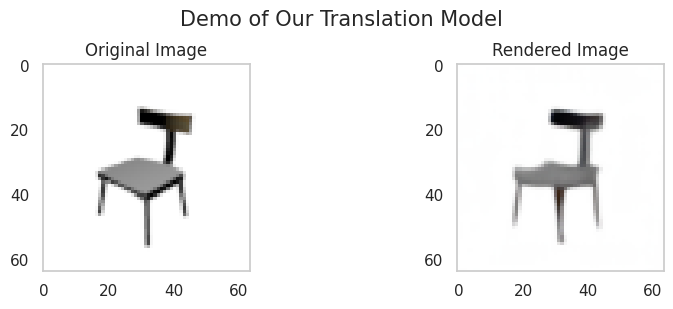

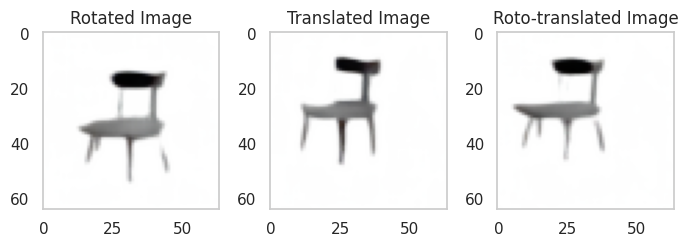

In [7]:
""" DEMO: We are currently downsampling the image but lose quite a bit of the image quality doing this
"""

# Load trained chairs modellocal_path
model_path = main_path + 'src/train_results/2023-05-14_16-54_trans_lr2e-4/best_model.pt'

# You can also try loading other examples (e.g. 'chair1.png')
img_path  = main_path + 'src/imgs/example-data/chair4_small.png'

scene, model, original_img, rendered_img = render_image(model_path, img_path, downsample = False)

# ---------------------------------------------------------
# Transform and render image 
# ---------------------------------------------------------
transformations = transformation_dict(20., 0., 0, .1, .1)

# Rotate scene
rotations = transformation_dict(azimuth = transformations['azimuth'], elevation = transformations['elevation'])
roto_scene = transform_scene(model, scene, init_camera_pos, rotations)


# Translate Scene
translations = transformation_dict(x = transformations['xyz'][0], 
                                   y = transformations['xyz'][1], 
                                   z = transformations['xyz'][2])
trans_scene = transform_scene(model, scene, init_camera_pos, translations)

# Roto-Translate Scene
roto_trans_scene = transform_scene(model, scene,init_camera_pos, transformations)


images = [original_img, rendered_img, roto_scene, trans_scene, roto_trans_scene]
keys = ['Original Image', 'Rendered Image', 'Rotated Image', 'Translated Image', 'Roto-translated Image']

# Plot without transformations
fig = display_transformations(images[:2], keys[:2], fsize = (9.8, 3))    
fig.suptitle('Demo of Our Translation Model', size = 15)
fig.subplots_adjust(top=0.8)

# Plot with transformations
fig = display_transformations(images[2:], keys[2:], fsize = (7, 3))
plt.tight_layout()

#### 3.3.2 Roto-Translations

The motivation for our research was to extend the equivariant neural rendering model to be able to produce novel views for any camera position in 3D space. Roto-translations fulfill this requirement. More specifically, we can cover all 3D positions by limiting the azimuth angle to a range of -180 to 180 degrees and the elevation angle to a range of -90 to 90 degrees. The latter avoids a flipping of the camera which causes problems with the compatibility of translations in Blender vs translations in the model. Nonetheless, by being able to rotate the camera along the azimuth, we can still cover all necessary views. For translations, we can obviously only cover a finite distances, therefore we chose the same range as in section 3.2 (-0.5 to 0.5 for all directions).

*** Show the new model and present the results ***

## 4. Conclusion

- Some preliminary results (working model)

## 5. Contributions 

Close the notebook with a description of the each students' contribution.